reccupération de tout les messgages

In [1]:
from pymongo import MongoClient

# Requires the PyMongo package.
# https://api.mongodb.com/python/current

client = MongoClient('mongodb://localhost:27017/')
filter={
    
}

result = client['mooc']['sample_cleaned'].find(
  filter=filter
)

results = list(result)

faire de nos données un dataframe pandas

In [2]:
import pandas as pd
df = pd.DataFrame(results)
df.head()

,_id,id,body,created_at,parent_id,thread_id,course_id,type,username,user_id,courseware_title,endorsed,depth
0,682dc5dd26080dac37efd544,52ef4b71ab137b00720007d4,Dans le cadre de mes études d'ingénieur j'ai é...,2014-02-03T07:55:29Z,,,CNAM/01002/Trimestre_1_2014,thread,qb,281811,Entre nous / Presentez-vous,False,
1,682dc5dd26080dac37efd545,52ef5f60919cec5e32000962,jeune ingénieur occupant le post d'un Project ...,2014-02-03T09:20:32Z,,52ef4b71ab137b00720007d4,CNAM/01002/Trimestre_1_2014,comment,MountacirAmar,140372,,False,0
2,682dc5dd26080dac37efd546,52ef4d79b4907d2e23000996,"Bonjour,\nje suis actuellement une formation d...",2014-02-03T08:04:09Z,,,CNAM/01002/Trimestre_1_2014,thread,fidji,268092,Entre nous / Presentez-vous,False,
3,682dc5dd26080dac37efd547,52ef73945c4baf9e610008a8,"Bonjour, fondatrice du l’Institut Européen pou...",2014-02-03T10:46:44Z,,52ef4d79b4907d2e23000996,CNAM/01002/Trimestre_1_2014,comment,ElenaThomas,264453,,False,0
4,682dc5dd26080dac37efd548,52efa3b5cfc81d7e410009a3,"Répartir les taches, former ses collaborateurs...",2014-02-03T14:12:05Z,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,CNAM/01002/Trimestre_1_2014,comment,BEJA,134144,,False,1


Normalisation de nos dates

In [3]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['created_at']

0        2014-02-03 07:55:29+00:00
1        2014-02-03 09:20:32+00:00
2        2014-02-03 08:04:09+00:00
3        2014-02-03 10:46:44+00:00
4        2014-02-03 14:12:05+00:00
                    ...           
178503   2022-06-23 18:56:10+00:00
178504   2022-06-25 17:37:11+00:00
178505   2022-06-26 14:34:08+00:00
178506   2022-06-26 18:03:34+00:00
178507   2022-06-28 08:17:43+00:00
Name: created_at, Length: 178508, dtype: datetime64[ns, UTC]

creer une collones pour la récence de chaques messages calculé en jours

In [4]:
import datetime
import pytz
now = datetime.datetime.now(pytz.UTC)
print(now)
df['recency'] = (now - df['created_at']).dt.total_seconds().astype(int)
df['recency']

2025-05-22 14:11:54.739131+00:00


0         356508985
1         356503882
2         356508465
3         356498710
4         356486389
            ...    
178503     91912544
178504     91744483
178505     91669066
178506     91656500
178507     91518851
Name: recency, Length: 178508, dtype: int64

detection de la langue et suppression des messages qui ne sont pas francais

In [7]:
from langdetect import detect, LangDetectException

def detect_lang_safe(text):
    try:
        if isinstance(text, str) and text.strip():
            return detect(text)
        else:
            return "NA"
    except LangDetectException:
        return "NA"

df['lang'] = df['body'].apply(detect_lang_safe)
df = df[df['lang'] == 'fr']

Detection des sentiments et attribution a chaques messages

In [8]:
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer

# Créer UNE instance globale
analyzer = SentimentIntensityAnalyzer()

def classify_sentiment_label_fr(text):
    
    score = analyzer.polarity_scores(text)['compound']
    if score > 0.1:
        label = 0
    elif score < -0.1:
        label = 1
    else:
        label = 2
    return label


df['sentiment'] = df['body'].apply(lambda x: classify_sentiment_label_fr(x))





collone avec le nombre de messages

In [9]:
df['frequency'] = df.groupby('user_id')['user_id'].transform('count')

reccuperation des collones qui m'interrese

In [10]:
df_cluster = df[['user_id', 'recency','frequency','lang', 'sentiment' ]]

feature ingeeniring de toutes mes collones 

In [11]:
df_cluster2 = df_cluster.groupby('user_id').agg({
    'recency': 'min',
    'frequency': 'first',
    'lang': lambda x: x.mode()[0] if not x.mode().empty else "NA",
    'sentiment': lambda x: x.mode()[0] if not x.mode().empty else "NA",
}).reset_index()

suppression des outliers

In [18]:
ids_to_remove = ['', '71110']
df_cluster2 = df_cluster2[~df_cluster2['user_id'].isin(ids_to_remove)]

encodage de la collone langue

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_cluster2['lang_num'] = le.fit_transform(df_cluster2['lang'])

fusion de mes collones en 1 pour encoder

In [20]:
# features = [col for col in df_cluster2.columns if df_cluster2[col].dtype in ['float64', 'int64'] and col not in ['user_id']]  # adapte selon tes colonnes
# X = df_cluster2[features].values

In [14]:
# from sklearn.preprocessing import StandardScaler

# features = [col for col in df_cluster2.columns if df_cluster2[col].dtype in ['float64', 'int64'] and col not in ['user_id', 'cluster', 'PCA1', 'PCA2']]
# X = df_cluster2[features].values
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

methode du coude pour identifier le nombre de clusters adequats

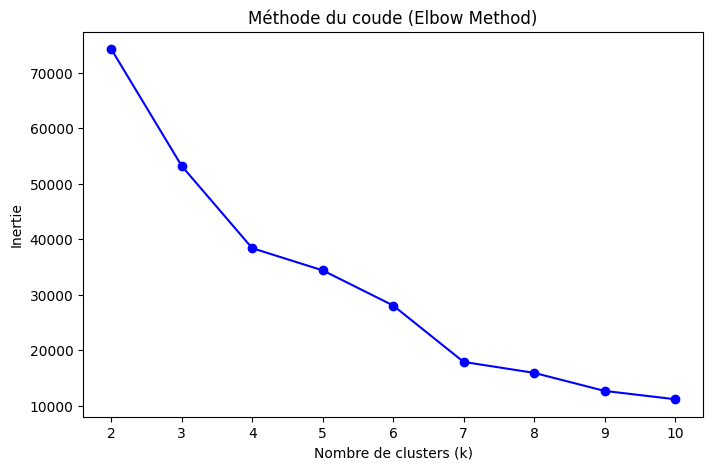

In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

features = ['recency', 'frequency', 'lang_num', 'sentiment']
X = df_cluster2[features]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
K_range = range(2, 11)  # essaie de 2 à 10 clusters

for k in K_range:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, 'o-', color='blue')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude (Elbow Method)')
plt.show()


clusterisation kmeans

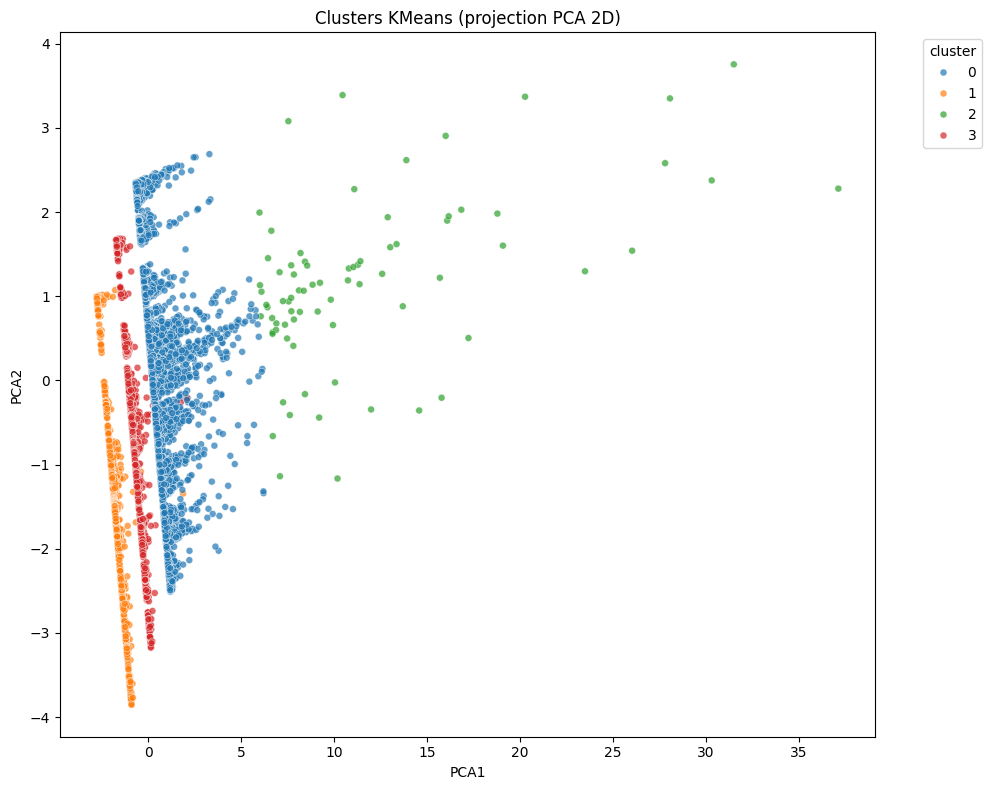

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. colonnes numériques pertinentes
features = [col for col in df_cluster2.columns if df_cluster2[col].dtype in ['float64', 'int64'] and col not in ['user_id', 'cluster', 'PCA1', 'PCA2']]
X = df_cluster2[features].values

# 2. Standardiser 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Appliquer KMeans
k = 4  # Choisis le nombre de clusters que tu veux tester !
kmeans = KMeans(n_clusters=k, random_state=42)
df_cluster2['cluster'] = kmeans.fit_predict(X_scaled)

# 4. Réduction en 2D pour affichage
X_pca = PCA(n_components=2).fit_transform(X_scaled)
df_cluster2['PCA1'], df_cluster2['PCA2'] = X_pca[:, 0], X_pca[:, 1]

# 5. Scatterplot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='cluster',
    palette='tab10',
    data=df_cluster2,
    legend='full',
    s=25, alpha=0.7
)
plt.title("Clusters KMeans (projection PCA 2D)")
plt.legend(title='cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.tight_layout()
plt.show()


In [ ]:
import plotly.express as px

# moyennes de chaque cluster dans une table 
cluster_means = df_cluster2.groupby('cluster')[features].mean().reset_index()

# Création du scatterplot interactif
fig = px.scatter(
    df_cluster2,
    x='PCA1',
    y='PCA2',
    color='cluster',
    hover_data=features + ['user_id'],   # Tu peux ajouter d'autres colonnes ici pour afficher dans le tooltip
    title="Clusters KMeans (projection PCA 2D - interactif)"
)

fig.write_html('clusters_kmeans_interactif.html')